# 06 — Rotación en 2D

## Teoría (matrices 2×2)

La **rotación** en 2D alrededor del **origen** se define mediante la matriz:

$\mathbf{R}(\theta)=$

$\begin{bmatrix}
\cos\theta & -\sin\theta\\
\sin\theta & \phantom{-}\cos\theta
\end{bmatrix}$,
$\qquad$
$\begin{bmatrix}x_2\\y_2\end{bmatrix}$
=
$\mathbf{R}(\theta)$
$\begin{bmatrix}x_1\\y_1\end{bmatrix}$


- $(\theta>0)$ es **antihorario** en el sistema cartesiano usual (eje (y) hacia arriba).
- En imágenes, el eje (y) apunta **hacia abajo** (origen en la esquina superior izquierda). Por ello, una rotación **antihoraria** matemática puede **verse** como horaria en la pantalla.

Para rotar alrededor de un **centro** $((c_x,c_y)$) distinto del origen, componemos traslaciones:
1. Trasladar el centro al origen.
2. Aplicar $(\mathbf{R}(\theta)$).
3. Regresar al centro.

En forma afín 2×3 (para OpenCV):
$
\mathbf{M}=
\begin{bmatrix}
\cos\theta & -\sin\theta & t_x\\
\sin\theta & \phantom{-}\cos\theta & t_y
\end{bmatrix}.
$


## Implementación en OpenCV

Dos manerar:
1. `cv2.getRotationMatrix2D((cx,cy), angle_deg, scale)` + `cv2.warpAffine` (rotación simple en el mismo lienzo).  
2. **Opción recomendada:** `getRotationMatrix2D` + **ajuste del bounding box** para evitar recortes.  


✅ Imagen cargada: (512, 512, 3) uint8


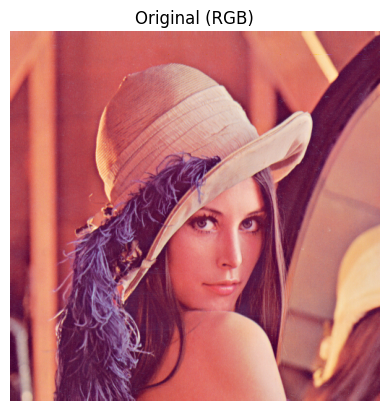

In [1]:
# ✅ Importar librerías y cargar imagen
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_bgr = cv2.imread(r"C:\Users\20808\Documents\Repositorios\Vision_en_Robotica\imagenes\lenna.png")  # Cambia la ruta si es necesario

if img_bgr is None:
    raise FileNotFoundError("⚠️ No se pudo cargar la imagen. Verifica la ruta.")
print("✅ Imagen cargada:", img_bgr.shape, img_bgr.dtype)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb); plt.title("Original (RGB)"); plt.axis("off"); plt.show()


### A) `cv2.getRotationMatrix2D` alrededor del centro

OpenCV define el ángulo en **grados**, positivo = **antihorario** respecto al centro indicado.


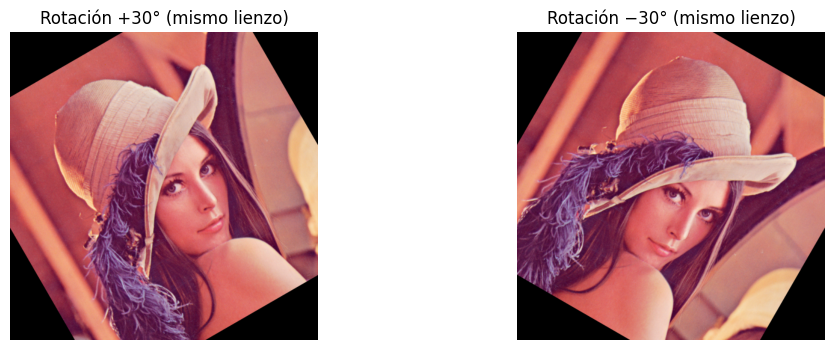

In [ ]:
h, w = img_rgb.shape[:2]
center = (w/2.0, h/2.0)

angle = 30   # grados
scale = 1.0

M = cv2.getRotationMatrix2D(center, angle, scale)
rot_30 = cv2.warpAffine(img_rgb, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

M2 = cv2.getRotationMatrix2D(center, -30, 1.0)
rot_m30 = cv2.warpAffine(img_rgb, M2, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(rot_30);  plt.title("Rotación +30°"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(rot_m30); plt.title("Rotación −30°"); plt.axis("off")
plt.show()


### B) **Opción recomendada**: `getRotationMatrix2D` + ajuste de **bounding box** (sin recortes)

1. Obtenemos `M` con `getRotationMatrix2D` alrededor del centro.  
2. Calculamos el nuevo tamaño $(new_w, new_h)$ usando $|cosθ| y |sinθ|$.  
3. Ajustamos la traslación de `M` para centrar la imagen. 


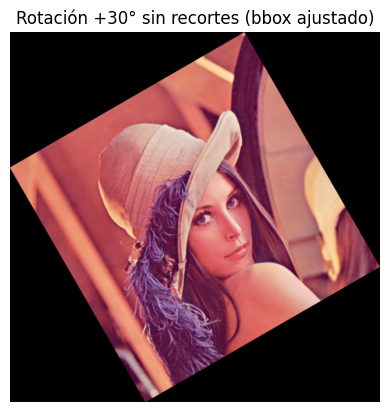

In [3]:
angle = 30  # grados

M = cv2.getRotationMatrix2D(center, angle, 1.0)

cos = abs(M[0,0])
sin = abs(M[0,1])

new_w = int((h * sin) + (w * cos))
new_h = int((h * cos) + (w * sin))

M[0,2] += (new_w / 2.0) - center[0]
M[1,2] += (new_h / 2.0) - center[1]

rot_full = cv2.warpAffine(img_rgb, M, (new_w, new_h),
                          flags=cv2.INTER_LINEAR,
                          borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

plt.imshow(rot_full); plt.title("Rotación +30° sin recortes (bbox ajustado)"); plt.axis("off"); plt.show()


### Modos de borde (opcional)

Probar `BORDER_REPLICATE` o `BORDER_REFLECT` puede resultar visualmente más agradable que negro constante.


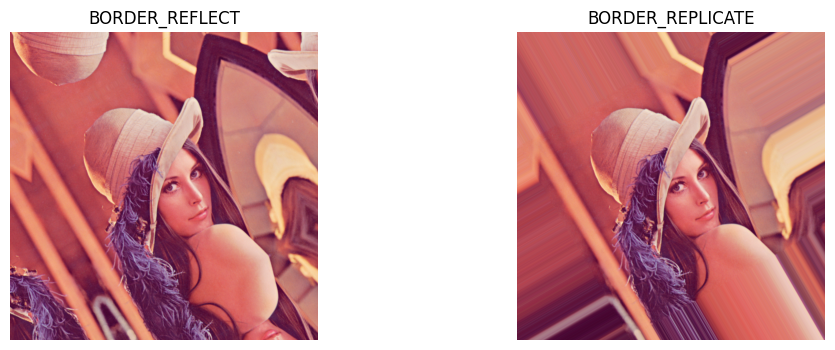

In [4]:
rot_reflect = cv2.warpAffine(img_rgb, M, (new_w, new_h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
rot_repl    = cv2.warpAffine(img_rgb, M, (new_w, new_h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(rot_reflect); plt.title("BORDER_REFLECT"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(rot_repl);    plt.title("BORDER_REPLICATE"); plt.axis("off")
plt.show()


### Guardado (opcional) en la misma carpeta de la imagen original

In [5]:
import os
img_path = r"C:\Users\20808\Documents\Repositorios\Vision_en_Robotica\imagenes\lenna.png"
carpeta = os.path.dirname(img_path)
nombre, ext = os.path.splitext(os.path.basename(img_path))

cv2.imwrite(os.path.join(carpeta, f"{nombre}_rot_+30_samecanvas{ext}"), cv2.cvtColor(rot_30,  cv2.COLOR_RGB2BGR))
cv2.imwrite(os.path.join(carpeta, f"{nombre}_rot_-30_samecanvas{ext}"), cv2.cvtColor(rot_m30, cv2.COLOR_RGB2BGR))
cv2.imwrite(os.path.join(carpeta, f"{nombre}_rot_bbox{ext}"),           cv2.cvtColor(rot_full, cv2.COLOR_RGB2BGR))


True

## Aplicaciones en robótica

- **Registro de vistas**: alinear imágenes con pequeñas rotaciones entre frames (estabilización visual).  
- **Deskew**: corregir inclinación de etiquetas/códigos/planos para lectura o inspección.  
- **Fusión IMU–cámara**: compensar rotaciones de cámara conocidas por IMU.  
- **Data augmentation**: rotaciones pequeñas para robustecer detectores/segmentadores.  
- **Calibración**: pruebas de sensibilidad de algoritmos a la orientación del sensor.  
